# Robyn: Marketing Mix Modeling Application

This notebook demonstrates the usage of Robyn, a Marketing Mix Modeling (MMM) application. 
We'll go through the main steps of performing robyn_inputs and robyn_engineering.



## 1. Import Required Libraries. Define Paths.

First, be sure to setup your virtual environment. Be sure to switch over to your new environment in this notebook. 

-```cd {root_folder}```

-```python3 -m yourvenv```

-```source yourvenv/bin/activate```

-```cd Robyn/python```

-```pip install -r requirements.txt```


Then import the necessary libraries. Make sure to define your paths below.



In [1]:
import sys

# Add Robyn to path
sys.path.append("/Users/yijuilee/robynpy_release_reviews/Robyn/python/src")

In [2]:
import os
import pandas as pd
from typing import Dict
from robyn.data.entities.mmmdata import MMMData
from robyn.data.entities.enums import AdstockType
from robyn.data.entities.holidays_data import HolidaysData
from robyn.data.entities.hyperparameters import Hyperparameters, ChannelHyperparameters
from robyn.modeling.entities.modelrun_trials_config import TrialsConfig
from robyn.modeling.model_executor import ModelExecutor
from robyn.modeling.entities.enums import NevergradAlgorithm, Models
from robyn.modeling.feature_engineering import FeatureEngineering

2024-11-15 00:22:49,016 - robyn - INFO - Logging is set up to console only.
/Users/yijuilee/robynpy_release_reviews/robynvenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2.1 Load Mock R data

We need to set the base path for the data directory.
Create a .env file in the same directory as your notebook and put in define the path to the data dir.
for example: ROBYN_BASE_PATH=.../Robyn/R/data

In [3]:
# Read the simulated data and holidays data
dt_simulated_weekly = pd.read_csv(
    "/Users/yijuilee/robynpy_release_reviews/Robyn/python/src/robyn/tutorials/resources/dt_simulated_weekly.csv"
)

dt_prophet_holidays = pd.read_csv(
    "/Users/yijuilee/robynpy_release_reviews/Robyn/python/src/robyn/tutorials/resources/dt_prophet_holidays.csv"
)

## Setup MMM Data

We will now set up the MMM data specification which includes defining the dependent variable, independent variables, and the time window for analysis.

In [4]:
from robyn.tutorials.utils.data_mapper import load_data_from_json, import_input_collect, import_output_models
%load_ext autoreload
%autoreload 2

# Load data from JSON exported from R
raw_input_collect = load_data_from_json(
    "/Users/yijuilee/project_robyn/original/Robyn_original_2/Robyn/robyn_api/data/Pareto_50_InputCollect.json"
)
raw_output_models = load_data_from_json(
    "/Users/yijuilee/project_robyn/original/Robyn_original_2/Robyn/robyn_api/data/Pareto_50_OutputModels.json"
)

# Convert R data to Python objects
r_input_collect = import_input_collect(raw_input_collect)
r_output_models = import_output_models(raw_output_models)

# Extract individual components
r_mmm_data = r_input_collect["mmm_data"]
r_featurized_mmm_data = r_input_collect["featurized_mmm_data"]
r_holidays_data = r_input_collect["holidays_data"]
r_hyperparameters = r_input_collect["hyperparameters"]

Adjusted window_start to the closest date in the data: 2016-01-04 00:00:00
Adjusted window_end to the closest date in the data: 2018-12-31 00:00:00
Debug: R output data keys: ['trial1', 'trial2', 'trial3', 'trial4', 'trial5']
Data for trial1: Keys = ['resultCollect', 'hyperBoundNG', 'hyperBoundFixed']
Debug: resultCollect keys for trial1: ['resultHypParam', 'xDecompAgg', 'decompSpendDist', 'iter', 'elapsed.min']
Debug: Sample resultHypParam for trial1: [{'facebook_S_alphas': 1.98202923325, 'facebook_S_gammas': 0.58424338159, 'facebook_S_thetas': 0.09072730547999999, 'newsletter_alphas': 1.7514167265, 'newsletter_gammas': 0.6585122811199999, 'newsletter_thetas': 0.22826231587, 'ooh_S_alphas': 1.9350874957500002, 'ooh_S_gammas': 0.80499137605, 'ooh_S_thetas': 0.26847073588000003, 'print_S_alphas': 1.3471347205000002, 'print_S_gammas': 0.6602001640299999, 'print_S_thetas': 0.34398200833000003, 'search_S_alphas': 1.835435262, 'search_S_gammas': 0.6915214566899999, 'search_S_thetas': 0.1125

In [5]:
def setup_mmm_data(dt_simulated_weekly) -> MMMData:

    mmm_data_spec = MMMData.MMMDataSpec(
        dep_var="revenue",
        dep_var_type="revenue",
        date_var="DATE",
        context_vars=["competitor_sales_B", "events"],
        paid_media_spends=["tv_S", "ooh_S", "print_S", "facebook_S", "search_S"],
        paid_media_vars=["tv_S", "ooh_S", "print_S", "facebook_I", "search_clicks_P"],
        organic_vars=["newsletter"],
        window_start="2016-01-01",
        window_end="2018-12-31",
    )

    return MMMData(data=dt_simulated_weekly, mmmdata_spec=mmm_data_spec)


mmm_data = setup_mmm_data(dt_simulated_weekly)
mmm_data.data.head()

Adjusted window_start to the closest date in the data: 2016-01-04 00:00:00
Adjusted window_end to the closest date in the data: 2018-12-31 00:00:00


,DATE,revenue,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,events,newsletter
0,2015-11-23,2.754372e+06,22358.346667,0.0,12728.488889,2.430128e+07,0.000000,0.000000,8125009,7607.132915,na,19401.653846
1,2015-11-30,2.584277e+06,28613.453333,0.0,0.000000,5.527033e+06,9837.238486,4133.333333,7901549,1141.952450,na,14791.000000
2,2015-12-07,2.547387e+06,0.000000,132278.4,453.866667,1.665159e+07,12044.119653,3786.666667,8300197,4256.375378,na,14544.000000
3,2015-12-14,2.875220e+06,83450.306667,0.0,17680.000000,1.054977e+07,12268.070319,4253.333333,8122883,2800.490677,na,2800.000000
4,2015-12-21,2.215953e+06,0.000000,277336.0,0.000000,2.934090e+06,9467.248023,3613.333333,7105985,689.582605,na,15478.000000


## Feature Preprocessing

We will perform feature engineering to prepare the data for modeling. This includes transformations like adstock and other preprocessing steps.

In [6]:
hyperparameters = Hyperparameters(
    {
        "facebook_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0, 0.3],
        ),
        "print_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.1, 0.4],
        ),
        "tv_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.3, 0.8],
        ),
        "search_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0, 0.3],
        ),
        "ooh_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.1, 0.4],
        ),
        "newsletter": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.1, 0.4],
        ),
    },
    adstock=AdstockType.GEOMETRIC,
    lambda_=[0, 1],
    train_size=[0.5, 0.8],
)

print("Hyperparameters setup complete.")

Hyperparameters setup complete.


In [7]:
# Create HolidaysData object
holidays_data = HolidaysData(
    dt_holidays=dt_prophet_holidays,
    prophet_vars=["trend", "season", "holiday"],
    prophet_country="DE",
    prophet_signs=["default", "default", "default"],
)
# Setup FeaturizedMMMData
feature_engineering = FeatureEngineering(mmm_data, hyperparameters, holidays_data)

In [8]:
featurized_mmm_data = feature_engineering.perform_feature_engineering()

2024-11-15 00:22:50,902 - robyn.modeling.feature_engineering - INFO - Starting feature engineering process
2024-11-15 00:22:50,903 - robyn.modeling.feature_engineering - INFO - Starting Prophet decomposition
2024-11-15 00:22:50,904 - robyn.modeling.feature_engineering - INFO - Starting Prophet decomposition
/Users/yijuilee/robynpy_release_reviews/robynvenv/lib/python3.9/site-packages/prophet/forecaster.py:187: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
2024-11-15 00:22:51,558 - cmdstanpy - DEBUG - input tempfile: /var/folders/gm/g5cpl7110m96nfd1qr1xwnwc0000gn/T/tmpdwpkxi3r/dahdfrqs.json
2024-11-15 00:22:51,569 - cmdstanpy - DEBUG - input tempfile: /var/folders/gm/g5cpl7110m96nfd1qr1xwnw

All ind vars ['trend', 'season', 'holiday', 'competitor_sales_B', 'events', 'tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']


2024-11-15 00:22:51,920 - robyn.visualization.feature_visualization - INFO - Initializing FeaturePlotter
2024-11-15 00:22:51,921 - robyn.visualization.feature_visualization - INFO - Generating spend-exposure plot for channel: facebook_I
2024-11-15 00:22:52,060 - robyn.visualization.feature_visualization - INFO - Successfully generated spend-exposure plot for channel facebook_I


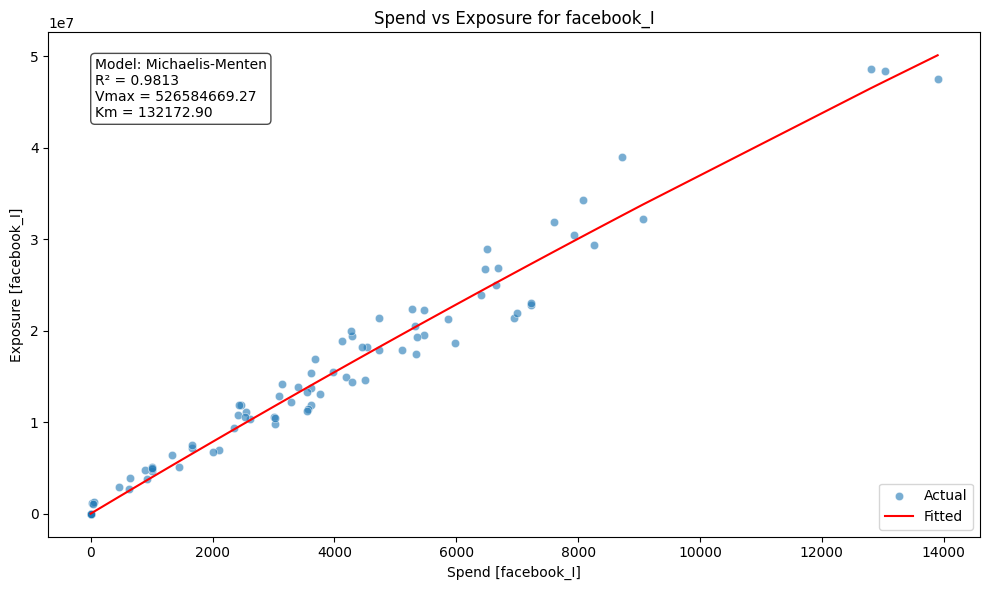

2024-11-15 00:22:52,160 - robyn.visualization.feature_visualization - INFO - Generating spend-exposure plot for channel: search_clicks_P
2024-11-15 00:22:52,331 - robyn.visualization.feature_visualization - INFO - Successfully generated spend-exposure plot for channel search_clicks_P


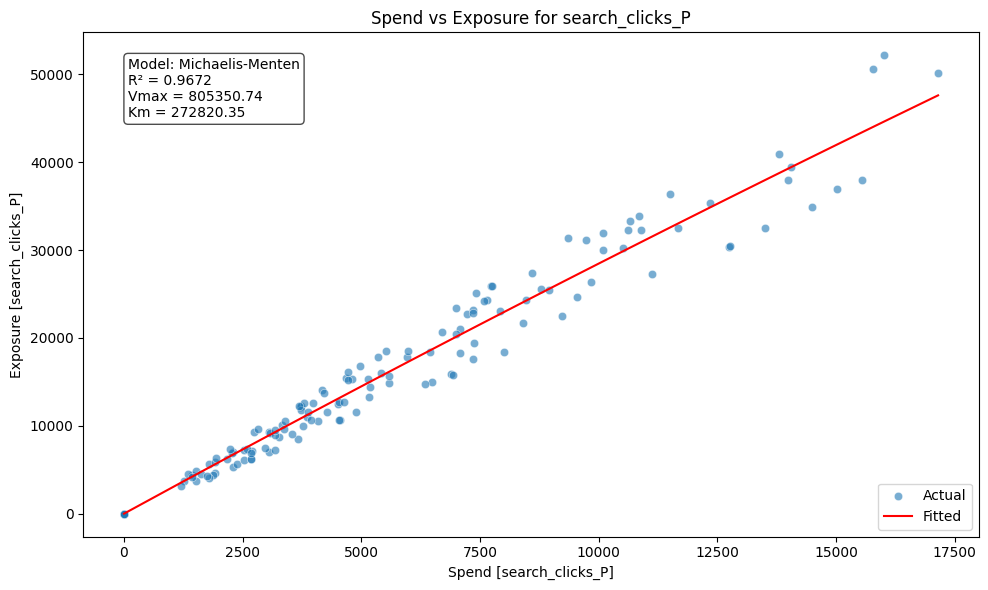

In [9]:
from robyn.visualization.feature_visualization import FeaturePlotter
import matplotlib.pyplot as plt
%matplotlib inline

# Create a FeaturePlotter instance
feature_plotter = FeaturePlotter(mmm_data, hyperparameters)
# Extract the list of results
results_list = featurized_mmm_data.modNLS["results"]
# Plot spend-exposure relationship for each channel in the results
for result in results_list:
    channel = result["channel"]
    try:
        fig = feature_plotter.plot_spend_exposure(featurized_mmm_data, channel)
        plt.show()
    except ValueError as e:
        print(f"Skipping {channel}: {str(e)}")

2024-11-15 00:28:23,032 - robyn.modeling.base_model_executor - INFO - Initializing BaseModelExecutor
2024-11-15 00:28:23,033 - robyn.modeling.model_executor - INFO - Starting model execution with model_name=Models.RIDGE
2024-11-15 00:28:23,033 - robyn.modeling.base_model_executor - INFO - Input validation successful
2024-11-15 00:28:23,034 - robyn.modeling.base_model_executor - INFO - Preparing hyperparameters
2024-11-15 00:28:23,037 - robyn.modeling.base_model_executor - INFO - Completed hyperparameter preparation with 20 parameters to optimize
2024-11-15 00:28:23,041 - robyn.modeling.model_executor - INFO - Initializing Ridge model builder
2024-11-15 00:28:23,042 - robyn.modeling.model_executor - INFO - Building models with configured parameters
2024-11-15 00:28:23,044 - robyn.modeling.ridge_model_builder - INFO - Collecting hyperparameters for optimization...


>>> Starting 5 trials with 54 iterations each using TwoPointsDE nevergrad algorithm on x cores...


Running trial 1 of total 5 trials: 100%|███████████████████████████████████
2024-11-15 00:28:28,446 - robyn.modeling.ridge_model_builder - INFO -  Finished in 0.09 mins
Running trial 2 of total 5 trials: 100%|███████████████████████████████████
2024-11-15 00:28:33,721 - robyn.modeling.ridge_model_builder - INFO -  Finished in 0.09 mins
Running trial 3 of total 5 trials: 100%|███████████████████████████████████
2024-11-15 00:28:38,985 - robyn.modeling.ridge_model_builder - INFO -  Finished in 0.09 mins
Running trial 4 of total 5 trials: 100%|███████████████████████████████████
2024-11-15 00:28:44,275 - robyn.modeling.ridge_model_builder - INFO -  Finished in 0.09 mins
Running trial 5 of total 5 trials: 100%|███████████████████████████████████
2024-11-15 00:28:49,533 - robyn.modeling.ridge_model_builder - INFO -  Finished in 0.09 mins
2024-11-15 00:28:49,540 - robyn.visualization.model_convergence_visualizer - INFO - Initialized ModelConvergenceVisualizer
2024-11-15 00:28:49,541 - robyn.

Model training complete.


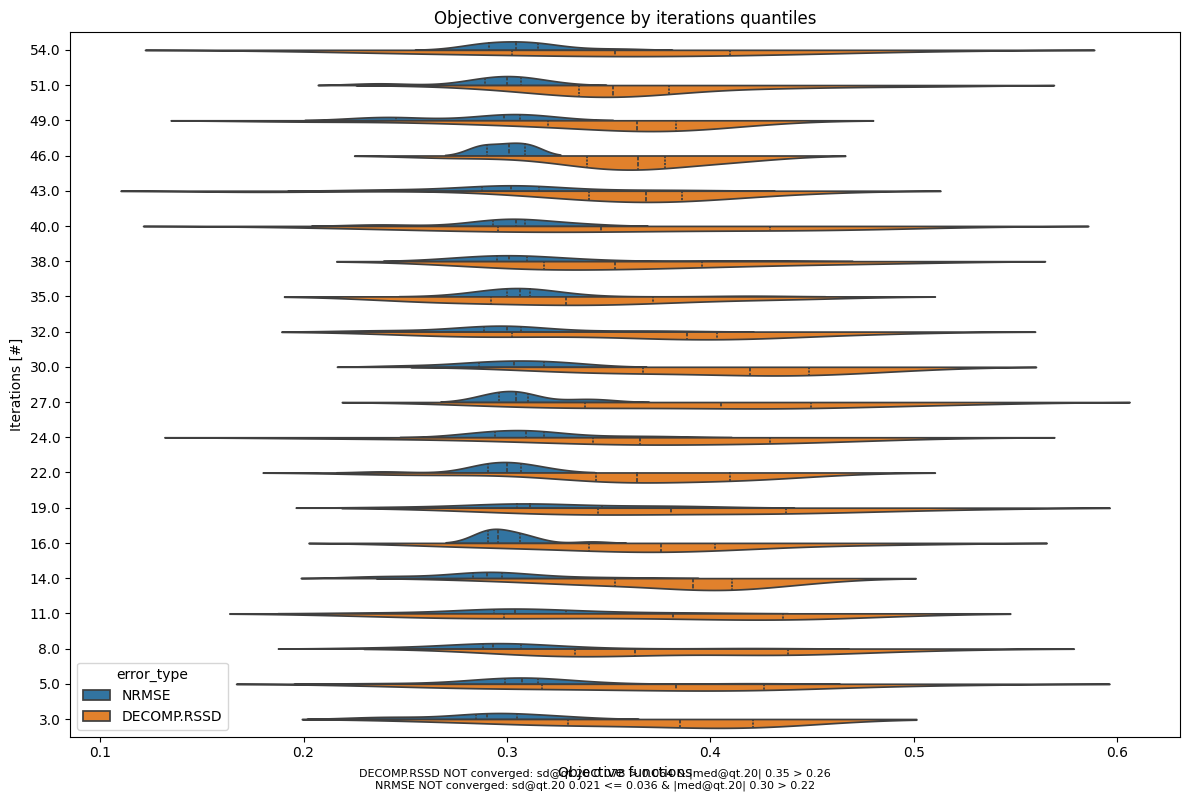

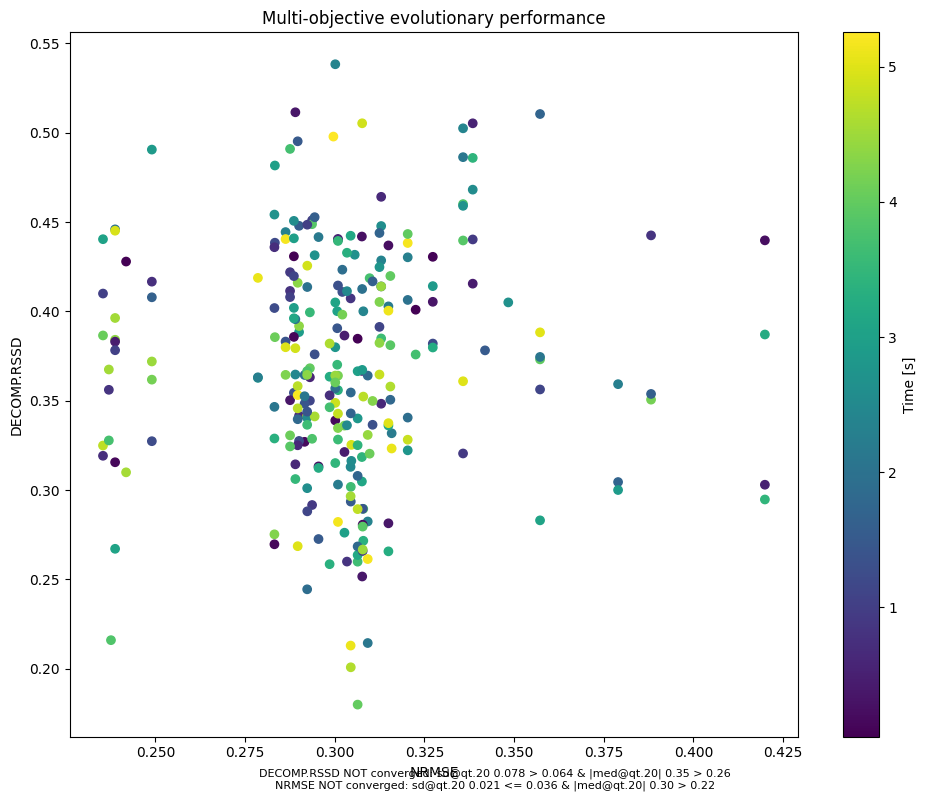

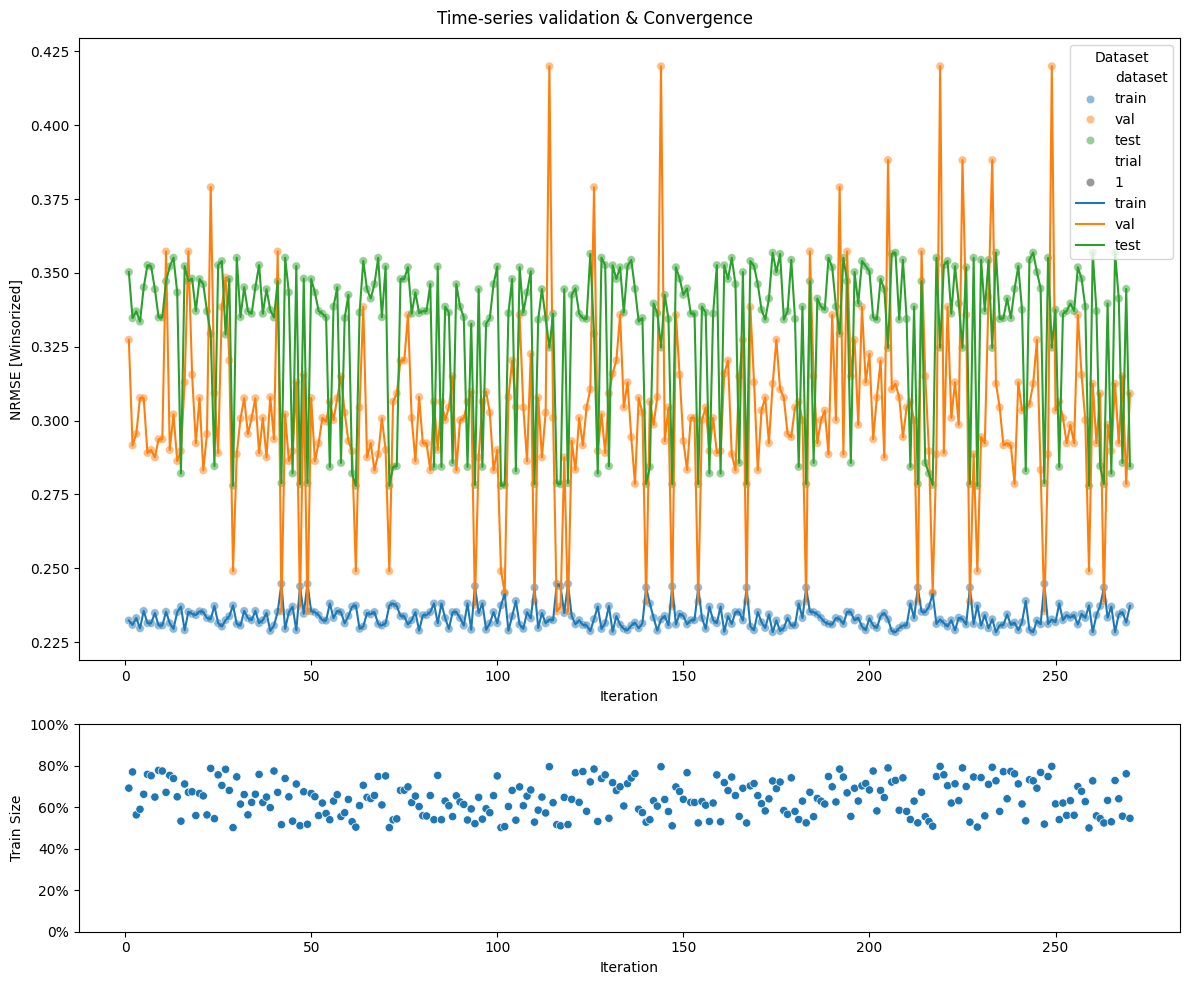

In [11]:
# Setup ModelExecutor
model_executor = ModelExecutor(
    mmmdata=r_mmm_data,
    holidays_data=r_holidays_data,
    hyperparameters=hyperparameters,
    calibration_input=None,  # Add calibration input if available
    featurized_mmm_data=r_featurized_mmm_data,
)

# Setup TrialsConfig
trials_config = TrialsConfig(iterations=54, trials=5)  # Set to the number of cores you want to use

print(
    f">>> Starting {trials_config.trials} trials with {trials_config.iterations} iterations each using {NevergradAlgorithm.TWO_POINTS_DE.value} nevergrad algorithm on x cores..."
)

# Run the model

output_models = model_executor.model_run(
    trials_config=trials_config,
    ts_validation=True,  # changed from True to False -> deacitvate
    add_penalty_factor=False,
    rssd_zero_penalty=True,
    cores=8,
    nevergrad_algo=NevergradAlgorithm.TWO_POINTS_DE,
    intercept=True,
    intercept_sign="non_negative",
    model_name=Models.RIDGE,
)
print("Model training complete.")

2024-11-15 00:28:51,331 - robyn.visualization.model_convergence_visualizer - INFO - Initialized ModelConvergenceVisualizer


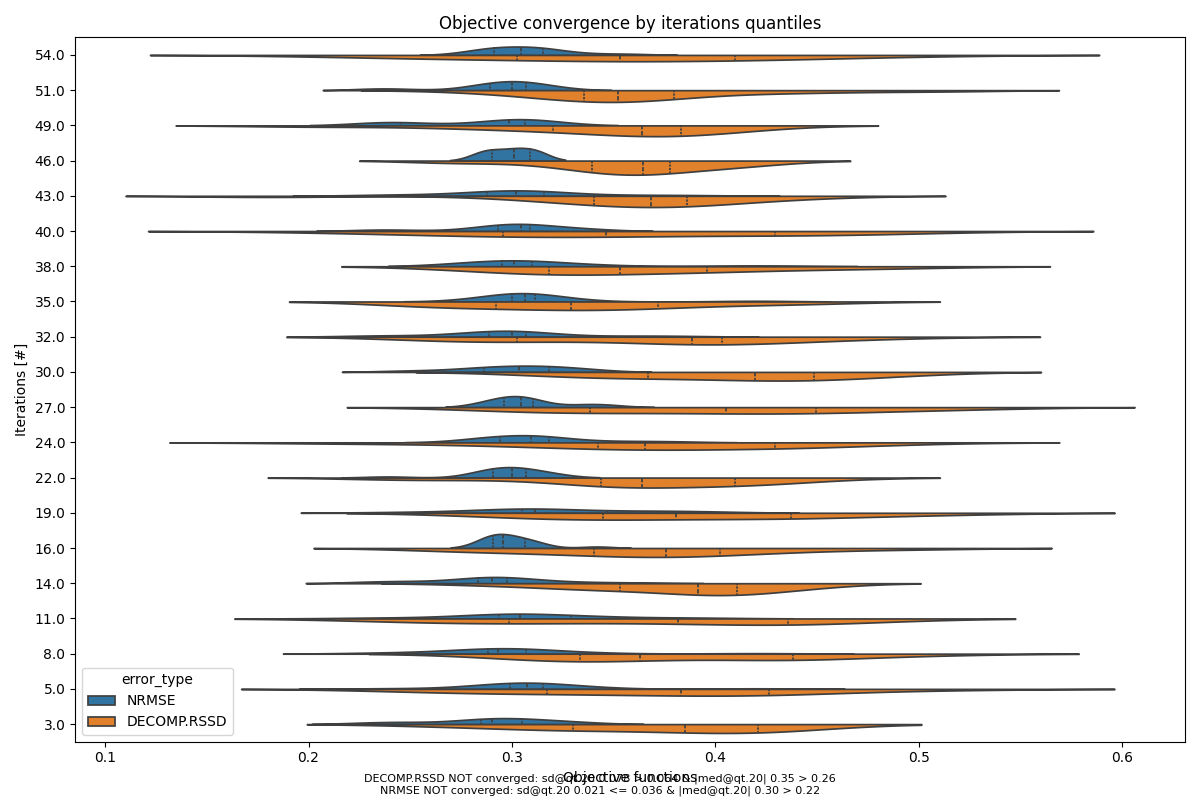

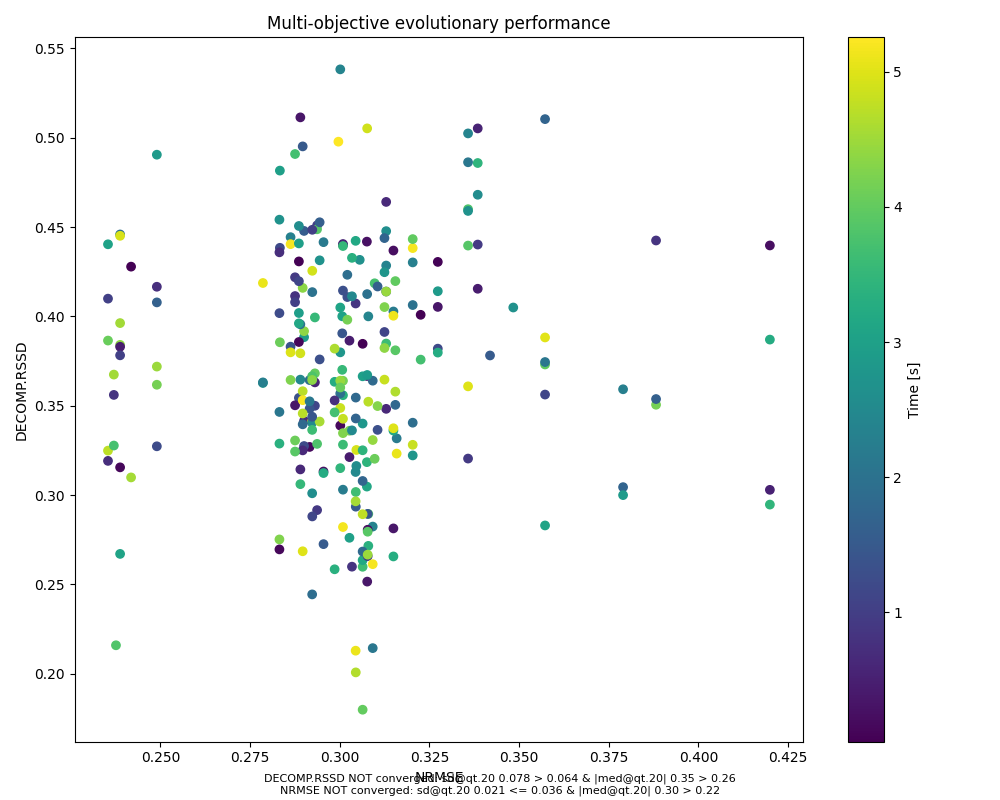

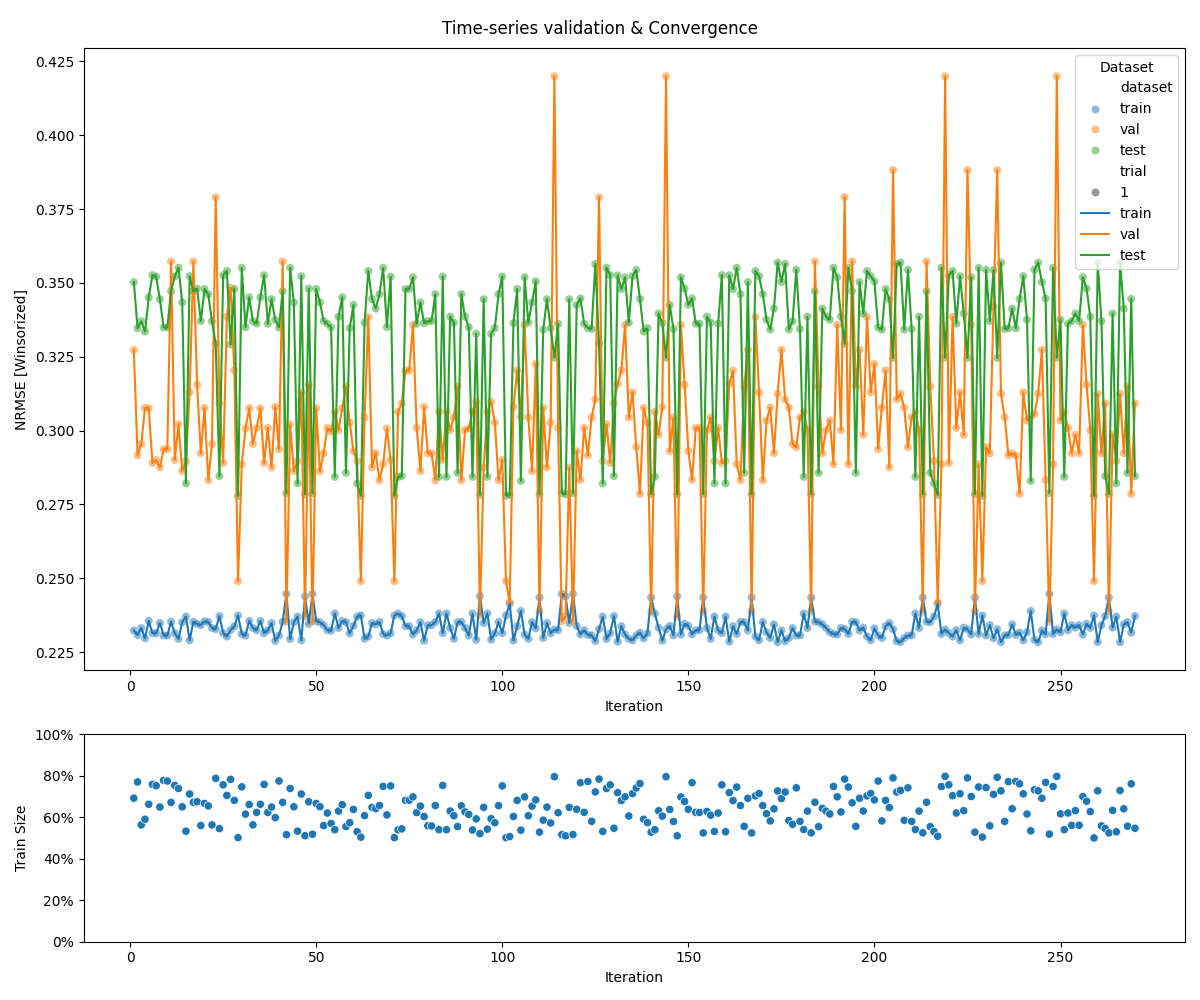

In [12]:
from IPython.display import Image, display
import base64
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from robyn.visualization.model_convergence_visualizer import ModelConvergenceVisualizer

model_visualizer = ModelConvergenceVisualizer(
    moo_distrb_plot=output_models.convergence["moo_distrb_plot"],
    ts_validation_plot=output_models.convergence["ts_validation_plot"],
    moo_cloud_plot=output_models.convergence["moo_cloud_plot"],
)

# 1. Display the MOO Distribution Plot
if "moo_distrb_plot" in output_models.convergence:
    model_visualizer.display_moo_distrb_plot()

# 2. Display the MOO Cloud Plot
if "moo_cloud_plot" in output_models.convergence:
    model_visualizer.display_moo_cloud_plot()

# 3. Display time series validation and convergence plots
if "ts_validation_plot" in output_models.convergence:
    model_visualizer.display_ts_validation_plot()

In [13]:
from robyn.tutorials.utils.data_mapper import load_data_from_json, import_input_collect, import_output_models
%load_ext autoreload
%autoreload 2

# Load data from JSON exported from R
raw_input_collect = load_data_from_json(
    "/Users/yijuilee/project_robyn/original/Robyn_original_2/Robyn/robyn_api/data/Pareto_50_InputCollect.json"
)
raw_output_models = load_data_from_json(
    "/Users/yijuilee/project_robyn/original/Robyn_original_2/Robyn/robyn_api/data/Pareto_50_OutputModels.json"
)

# Convert R data to Python objects
r_input_collect = import_input_collect(raw_input_collect)
r_output_models = import_output_models(raw_output_models)

# Extract individual components
r_mmm_data = r_input_collect["mmm_data"]
r_featurized_mmm_data = r_input_collect["featurized_mmm_data"]
r_holidays_data = r_input_collect["holidays_data"]
r_hyperparameters = r_input_collect["hyperparameters"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Adjusted window_start to the closest date in the data: 2016-01-04 00:00:00
Adjusted window_end to the closest date in the data: 2018-12-31 00:00:00
Debug: R output data keys: ['trial1', 'trial2', 'trial3', 'trial4', 'trial5']
Data for trial1: Keys = ['resultCollect', 'hyperBoundNG', 'hyperBoundFixed']
Debug: resultCollect keys for trial1: ['resultHypParam', 'xDecompAgg', 'decompSpendDist', 'iter', 'elapsed.min']
Debug: Sample resultHypParam for trial1: [{'facebook_S_alphas': 1.98202923325, 'facebook_S_gammas': 0.58424338159, 'facebook_S_thetas': 0.09072730547999999, 'newsletter_alphas': 1.7514167265, 'newsletter_gammas': 0.6585122811199999, 'newsletter_thetas': 0.22826231587, 'ooh_S_alphas': 1.9350874957500002, 'ooh_S_gammas': 0.80499137605, 'ooh_S_thetas': 0.26847073588000003, 'print_S_alphas': 1.3471347205000002, 'print_S_gammas': 0.6602001640299999, 'print_S_thetas': 0.34398200833000003, 'search_

In [14]:
from anytree import Node, RenderTree
from dataclasses import is_dataclass, asdict
import pandas as pd


def build_tree(data, parent_key="", limit_trials=False, limit_repeats=False):
    """
    Recursively build a tree structure from a dictionary, list, or dataclass.

    Args:
        data: The data structure (dict, list, or dataclass) to traverse.
        parent_key: The base key path for nested keys.
        limit_trials: Whether to limit the output to the first trial.
        limit_repeats: Whether to limit the output to the first occurrence of repeated keys.

    Returns:
        A tree node representing the structure of the data.
    """
    if is_dataclass(data):
        data = asdict(data)  # Convert dataclass to dictionary

    if isinstance(data, dict):
        node = Node(f"{parent_key} (dict)")
        for key, value in data.items():
            full_key = f"{parent_key}.{key}" if parent_key else key
            child_node = build_tree(value, full_key, limit_trials, limit_repeats)
            child_node.parent = node
        return node

    elif isinstance(data, list):
        node = Node(f"{parent_key} (list, length={len(data)})")
        item_structure = None
        repeat_count = 0
        for index, item in enumerate(data):
            full_key = f"{parent_key}[{index}]"
            if limit_trials and parent_key == "trials" and index > 0:
                break

            # Serialize the structure of the item for comparison
            current_structure = (
                str({k: type(v).__name__ for k, v in item.items()}) if isinstance(item, dict) else str(type(item))
            )

            if item_structure is None:
                item_structure = current_structure
                child_node = build_tree(item, full_key, limit_trials, limit_repeats)
                child_node.parent = node
            elif current_structure == item_structure:
                repeat_count += 1
            else:
                # If the structure changes, reset the counter and process the new structure
                if repeat_count > 0:
                    summary_node = Node(f"{parent_key} (repeats for {repeat_count} times)")
                    summary_node.parent = node
                item_structure = current_structure
                repeat_count = 0
                child_node = build_tree(item, full_key, limit_trials, limit_repeats)
                child_node.parent = node

        # Add a summary node if there are repeated structures at the end
        if repeat_count > 0:
            summary_node = Node(f"{parent_key} (repeats for {repeat_count} times)")
            summary_node.parent = node

        return node

    elif isinstance(data, pd.DataFrame):
        node = Node(f"{parent_key} (DataFrame: {data.shape})")
        for column in data.columns:
            dtype = data[column].dtype
            column_node = Node(f"{parent_key}.{column} (dtype: {dtype})")
            column_node.parent = node
        return node

    else:
        dtype = type(data).__name__
        return Node(f"{parent_key} (type: {dtype})")


# Assuming featurized_mmm_data is an instance of FeaturizedMMMData
python_tree = build_tree(output_models)
r_tree = build_tree(r_output_models)

# Visualize the tree
print("Python ModelOutputs Structure:")
for pre, fill, node in RenderTree(python_tree):
    print(f"{pre}{node.name}")


print("-" * 100)
print("R ModelOutputs Structure:")
for pre, fill, node in RenderTree(python_tree):
    print(f"{pre}{node.name}")

Python ModelOutputs Structure:
 (dict)
├── trials (list, length=5)
│   ├── trials[0] (dict)
│   │   ├── trials[0].result_hyp_param (DataFrame: (54, 39))
│   │   │   ├── trials[0].result_hyp_param.facebook_S_thetas (dtype: float64)
│   │   │   ├── trials[0].result_hyp_param.facebook_S_alphas (dtype: float64)
│   │   │   ├── trials[0].result_hyp_param.facebook_S_gammas (dtype: float64)
│   │   │   ├── trials[0].result_hyp_param.print_S_thetas (dtype: float64)
│   │   │   ├── trials[0].result_hyp_param.print_S_alphas (dtype: float64)
│   │   │   ├── trials[0].result_hyp_param.print_S_gammas (dtype: float64)
│   │   │   ├── trials[0].result_hyp_param.tv_S_thetas (dtype: float64)
│   │   │   ├── trials[0].result_hyp_param.tv_S_alphas (dtype: float64)
│   │   │   ├── trials[0].result_hyp_param.tv_S_gammas (dtype: float64)
│   │   │   ├── trials[0].result_hyp_param.search_S_thetas (dtype: float64)
│   │   │   ├── trials[0].result_hyp_param.search_S_alphas (dtype: float64)
│   │   │   ├── tria

In [15]:
# from anytree import Node, RenderTree
# from anytree.exporter import DotExporter
# from dataclasses import is_dataclass, asdict
# import pandas as pd


# def build_tree(data, parent_key="", limit_trials=True):
#     """
#     Recursively build a tree structure from a dictionary, list, or dataclass.

#     Args:
#         data: The data structure (dict, list, or dataclass) to traverse.
#         parent_key: The base key path for nested keys.
#         limit_trials: Whether to limit the output to the first trial.

#     Returns:
#         A tree node representing the structure of the data.
#     """
#     if is_dataclass(data):
#         data = asdict(data)  # Convert dataclass to dictionary

#     if isinstance(data, dict):
#         node = Node(parent_key)
#         for key, value in data.items():
#             full_key = f"{parent_key}.{key}" if parent_key else key
#             child_node = build_tree(value, full_key, limit_trials)
#             child_node.parent = node
#         return node
#     elif isinstance(data, list):
#         node = Node(parent_key)
#         for index, item in enumerate(data):
#             if limit_trials and parent_key == "trials" and index > 0:
#                 break
#             full_key = f"{parent_key}[{index}]"
#             child_node = build_tree(item, full_key, limit_trials)
#             child_node.parent = node
#         return node
#     elif isinstance(data, pd.DataFrame):
#         node = Node(f"{parent_key} (DataFrame: {data.shape})")
#         for column in data.columns:
#             column_node = Node(f"{parent_key}.{column}")
#             column_node.parent = node
#         return node
#     else:
#         return Node(parent_key)


# # Assuming output_models and r_output_models are instances of ModelOutputs
# python_tree = build_tree(output_models)
# r_tree = build_tree(r_output_models)

# # Visualize the trees
# print("Python ModelOutputs Structure:")
# for pre, fill, node in RenderTree(python_tree):
#     print(f"{pre}{node.name}")

# print("\nR ModelOutputs Structure:")
# for pre, fill, node in RenderTree(r_tree):
#     print(f"{pre}{node.name}")

In [16]:
import pandas as pd
import numpy as np
from typing import Dict, Any


def compare_model_values(py_output, r_output):
    """Compare key values between Python and R model outputs"""

    print("1. Basic Model Configuration Comparison:")
    basic_attrs = [
        "train_timestamp",
        "cores",
        "iterations",
        "intercept",
        "intercept_sign",
        "nevergrad_algo",
        "ts_validation",
        "add_penalty_factor",
    ]

    # Add debug prints
    print("\nDebugging attribute types:")
    for attr in basic_attrs:
        py_val = getattr(py_output, attr, None)
        r_val = getattr(r_output, attr, None)
        print(f"{attr:20s} - Python type: {type(py_val)} | R type: {type(r_val)}")
        print(f"{attr:20s} - Python value: {py_val} | R value: {r_val}")
        print("-" * 50)

    print("\n2. Trial Results Comparison (Descriptive Statistics):")
    if py_output.trials and r_output.trials:
        metrics = [
            "nrmse",
            "decomp_rssd",
            "mape",
            "rsq_train",
            "rsq_val",
            "rsq_test",
            "lambda_",
            "lambda_hp",
            "lambda_max",
            "lambda_min_ratio",
        ]
        # Convert trial results to DataFrames
        py_trials_df = pd.DataFrame(
            [{metric: getattr(trial, metric, np.nan) for metric in metrics} for trial in py_output.trials]
        )

        # Aggregate R trial metrics
        r_trials_df = pd.DataFrame(
            [
                {metric: getattr(trial, metric, pd.Series([np.nan])).mean() for metric in metrics}
                for trial in r_output.trials
            ]
        )
        # Ensure R trial data is numeric
        r_trials_df = r_trials_df.apply(pd.to_numeric, errors="coerce")
        # Calculate descriptive statistics
        py_desc = py_trials_df.describe()
        r_desc = r_trials_df.describe()
        # Print descriptive statistics
        print("\nPython Trial Descriptive Statistics:")
        print(py_desc)
        print("\nR Trial Descriptive Statistics:")
        print(r_desc)
        # Calculate and print differences
        diff_desc = py_desc - r_desc
        print("\nDifference in Descriptive Statistics:")
        print(diff_desc)

    print("\n3. Hyperparameter Comparison:")
    if hasattr(py_output, "hyper_updated") and hasattr(r_output, "hyper_updated"):
        py_hyper = py_output.hyper_updated
        r_hyper = r_output.hyper_updated

        # Find all unique keys
        all_keys = set(py_hyper.keys()) | set(r_hyper.keys())

        print("\nHyperparameter Values:")
        print(f"{'Parameter':30s} {'Python':>15s} {'R':>15s} {'Diff':>15s}")
        print("-" * 75)

        for key in sorted(all_keys):
            py_val = py_hyper.get(key, "N/A")
            r_val = r_hyper.get(key, "N/A")

            if isinstance(py_val, (int, float)) and isinstance(r_val, (int, float)):
                diff = abs(py_val - r_val)
                print(f"{key:30s} {py_val:15.6f} {r_val:15.6f} {diff:15.6f}")
            else:
                print(f"{key:30s} {str(py_val):15s} {str(r_val):15s} {'N/A':>15s}")

    print("\n4. Data Shape Comparison:")
    data_attrs = ["all_result_hyp_param", "all_x_decomp_agg", "all_decomp_spend_dist"]

    for attr in data_attrs:
        py_shape = getattr(py_output, attr).shape if hasattr(py_output, attr) else None
        r_shape = getattr(r_output, attr).shape if hasattr(r_output, attr) else None
        print(f"{attr:20s} - Python shape: {py_shape} | R shape: {r_shape}")


# Run the comparison
print("Starting detailed value comparison...\n")
compare_model_values(output_models, r_output_models)

Starting detailed value comparison...

1. Basic Model Configuration Comparison:

Debugging attribute types:
train_timestamp      - Python type: <class 'str'> | R type: <class 'str'>
train_timestamp      - Python value: 2024-11-15 00:28:23 | R value: 2024-11-13 05:13:54
--------------------------------------------------
cores                - Python type: <class 'int'> | R type: <class 'int'>
cores                - Python value: 8 | R value: 9
--------------------------------------------------
iterations           - Python type: <class 'int'> | R type: <class 'int'>
iterations           - Python value: 54 | R value: 50
--------------------------------------------------
intercept            - Python type: <class 'bool'> | R type: <class 'bool'>
intercept            - Python value: True | R value: True
--------------------------------------------------
intercept_sign       - Python type: <class 'str'> | R type: <class 'str'>
intercept_sign       - Python value: non_negative | R value: non

In [17]:
def get_param_dict(param):
    """Helper function to safely get parameter dictionary"""
    if hasattr(param, "__dict__"):
        return vars(param)
    elif isinstance(param, dict):
        return param
    else:
        return {}


def compare_hyperparameters(py_hyp, r_hyp):
    """Compare Hyperparameters with value previews - handles both dict and object structures"""
    print("\n=== Hyperparameters Comparison ===")
    print("\nAdstock type:")
    print(f"Python: {py_hyp.adstock}")
    print(f"R: {r_hyp.adstock}")

    # Compare hyperparameters for each channel with values
    print("\nChannel hyperparameters:")

    # Safely get channel lists
    py_channels = (
        py_hyp.hyperparameters.keys() if hasattr(py_hyp, "hyperparameters") and py_hyp.hyperparameters else []
    )
    r_channels = r_hyp.hyperparameters.keys() if hasattr(r_hyp, "hyperparameters") and r_hyp.hyperparameters else []

    # Print structure debug info
    print("\nDebug - Hyperparameters structure:")
    print(f"Python hyperparameters type: {type(py_hyp.hyperparameters)}")
    print(f"R hyperparameters type: {type(r_hyp.hyperparameters)}")

    for channel in set(py_channels) | set(r_channels):
        print(f"\nChannel: {channel}")

        # Python parameters
        if channel in py_channels:
            py_params = py_hyp.hyperparameters[channel]
            print("Python params:")
            param_dict = get_param_dict(py_params)
            for param_name, param_value in param_dict.items():
                if param_value is not None:
                    if isinstance(param_value, (list, tuple)):
                        print(f"{param_name}: {param_value[0] if param_value else None}")
                    else:
                        print(f"{param_name}: {param_value}")

        # R parameters
        if channel in r_channels:
            r_params = r_hyp.hyperparameters[channel]
            print("R params:")
            param_dict = get_param_dict(r_params)
            for param_name, param_value in param_dict.items():
                if param_value is not None:
                    if isinstance(param_value, (list, tuple)):
                        print(f"{param_name}: {param_value[0] if param_value else None}")
                    else:
                        print(f"{param_name}: {param_value}")


def describe_df_columns(df, prefix=""):
    """Helper function to describe each column in a DataFrame"""
    print(f"\n{prefix} Columns Summary:")
    for col in df.columns:
        try:
            if df[col].dtype.kind in "biufc":  # boolean, integer, unsigned integer, float, complex
                print(f"\n{col}:")
                print(df[col].describe())
        except:
            print(f"\nCould not generate statistics for {col}")


def compare_mmm_data(py_mmm_data, r_mmm_data):
    """Compare MMMData components with value previews"""
    print("\n=== MMMData Comparison ===")

    # Compare main data values
    print("\nMain data value comparison:")
    print("\nPython data summary:")
    describe_df_columns(py_mmm_data.data, "Python")
    print("\nR data summary:")
    describe_df_columns(r_mmm_data.data, "R")

    # Compare MMMDataSpec attributes
    print("\nMMMDataSpec attributes:")
    spec_attrs = [
        "all_media",
        "paid_media_spends",
        "context_vars",
        "dep_var_type",
        "rolling_window_start_which",
        "rolling_window_end_which",
        "rolling_window_length",
        "window_start",
        "window_end",
    ]

    for attr in spec_attrs:
        print(f"\n{attr}:")
        print(f"Python: {getattr(py_mmm_data.mmmdata_spec, attr)}")
        print(f"R: {getattr(r_mmm_data.mmmdata_spec, attr)}")


def compare_featurized_data(py_feat, r_feat):
    """Compare FeaturizedMMMData components with value previews"""
    print("\n=== FeaturizedMMMData Comparison ===")

    # Compare dt_mod values
    print("\ndt_mod value comparison:")
    print("\nPython dt_mod summary:")
    describe_df_columns(py_feat.dt_mod, "Python dt_mod")
    print("\nR dt_mod summary:")
    describe_df_columns(r_feat.dt_mod, "R dt_mod")

    # Compare dt_modRollWind values
    print("\ndt_modRollWind value comparison:")
    print("\nPython dt_modRollWind summary:")
    describe_df_columns(py_feat.dt_modRollWind, "Python dt_modRollWind")
    print("\nR dt_modRollWind summary:")
    describe_df_columns(r_feat.dt_modRollWind, "R dt_modRollWind")


def compare_model_outputs(py_model, r_model):
    """Compare ModelOutputs with value previews"""
    print("\n=== ModelOutputs Comparison ===")

    # Compare basic attributes
    attrs = ["cores", "iterations", "hyper_fixed", "ts_validation"]
    for attr in attrs:
        if hasattr(py_model, attr) and hasattr(r_model, attr):
            print(f"\n{attr}:")
            print(f"Python: {getattr(py_model, attr)}")
            print(f"R: {getattr(r_model, attr)}")

    if py_model.trials and r_model.trials:
        print("\n=== First Trial Comparison ===")

        # Compare result_hyp_param
        print("\nResult Hyperparameter Values:")
        if hasattr(py_model.trials[0], "result_hyp_param"):
            print("\nPython result_hyp_param summary:")
            describe_df_columns(py_model.trials[0].result_hyp_param, "Python")
        if hasattr(r_model.trials[0], "result_hyp_param"):
            print("\nR result_hyp_param summary:")
            describe_df_columns(r_model.trials[0].result_hyp_param, "R")

        # Compare x_decomp_agg
        print("\nX Decomp Agg Values:")
        if hasattr(py_model.trials[0], "x_decomp_agg"):
            print("\nPython x_decomp_agg summary:")
            describe_df_columns(py_model.trials[0].x_decomp_agg, "Python")
        if hasattr(r_model.trials[0], "x_decomp_agg"):
            print("\nR x_decomp_agg summary:")
            describe_df_columns(r_model.trials[0].x_decomp_agg, "R")

        # Compare decomp_spend_dist if available
        if hasattr(py_model.trials[0], "decomp_spend_dist") and hasattr(r_model.trials[0], "decomp_spend_dist"):
            print("\nDecomp Spend Distribution Values:")
            print("\nPython decomp_spend_dist summary:")
            describe_df_columns(py_model.trials[0].decomp_spend_dist, "Python")
            print("\nR decomp_spend_dist summary:")
            describe_df_columns(r_model.trials[0].decomp_spend_dist, "R")


def run_comprehensive_comparison(py_data, r_data):
    """Run all comparisons with value previews"""
    print("Starting comprehensive data comparison...")

    compare_mmm_data(py_data["mmm_data"], r_data["mmm_data"])
    compare_featurized_data(py_data["featurized_mmm_data"], r_data["featurized_mmm_data"])
    compare_hyperparameters(py_data["hyperparameters"], r_data["hyperparameters"])
    compare_model_outputs(py_data["model_outputs"], r_data["model_outputs"])


# Your existing data loading code remains the same
python_data = {
    "mmm_data": mmm_data,
    "featurized_mmm_data": featurized_mmm_data,
    "hyperparameters": hyperparameters,
    "model_outputs": output_models,
}

r_data = {
    "mmm_data": r_mmm_data,
    "featurized_mmm_data": r_featurized_mmm_data,
    "hyperparameters": r_hyperparameters,
    "model_outputs": r_output_models,
}

run_comprehensive_comparison(python_data, r_data)

Starting comprehensive data comparison...

=== MMMData Comparison ===

Main data value comparison:

Python data summary:

Python Columns Summary:

revenue:
count    2.080000e+02
mean     1.822143e+06
std      7.162286e+05
min      6.722500e+05
25%      1.165211e+06
50%      1.874514e+06
75%      2.378407e+06
max      3.827520e+06
Name: revenue, dtype: float64

tv_S:
count       208.000000
mean      14843.691218
std       28558.366546
min           0.000000
25%           0.000000
50%           0.000000
75%       18406.706667
max      158046.573333
Name: tv_S, dtype: float64

ooh_S:
count       208.000000
mean      43217.941026
std       83991.426655
min           0.000000
25%           0.000000
50%           0.000000
75%       50858.133333
max      500361.600000
Name: ooh_S, dtype: float64

print_S:
count      208.000000
mean      3728.632265
std       6483.070232
min          0.000000
25%          0.000000
50%          0.000000
75%       4767.833333
max      31922.311111
Name: print_S,

In [18]:
print("Python")
print(hyperparameters)

print("R")
print(r_input_collect["hyperparameters"])

Python
Hyperparameters(
  facebook_S=Hyperparameter(
  thetas=[0, 0.3],
  shapes=None,
  scales=None,
  alphas=[0.5, 3],
  gammas=[0.3, 1],
  penalty=None
)
  print_S=Hyperparameter(
  thetas=[0.1, 0.4],
  shapes=None,
  scales=None,
  alphas=[0.5, 3],
  gammas=[0.3, 1],
  penalty=None
)
  tv_S=Hyperparameter(
  thetas=[0.3, 0.8],
  shapes=None,
  scales=None,
  alphas=[0.5, 3],
  gammas=[0.3, 1],
  penalty=None
)
  search_S=Hyperparameter(
  thetas=[0, 0.3],
  shapes=None,
  scales=None,
  alphas=[0.5, 3],
  gammas=[0.3, 1],
  penalty=None
)
  ooh_S=Hyperparameter(
  thetas=[0.1, 0.4],
  shapes=None,
  scales=None,
  alphas=[0.5, 3],
  gammas=[0.3, 1],
  penalty=None
)
  newsletter=Hyperparameter(
  thetas=[0.1, 0.4],
  shapes=None,
  scales=None,
  alphas=[0.5, 3],
  gammas=[0.3, 1],
  penalty=None
)
)
R
Hyperparameters(
  facebook_S_alphas=[0.5, 3]
  facebook_S_gammas=[0.3, 1]
  facebook_S_thetas=[0, 0.3]
  print_S_alphas=[0.5, 3]
  print_S_gammas=[0.3, 1]
  print_S_thetas=[0.1, 0.4

In [19]:
# def compare_x_decomp_agg(py_model, r_model):
#     """Compare x_decomp_agg structure and values between Python and R"""
#     print("\nComparing x_decomp_agg:")
#     print("Python columns:", py_model.all_x_decomp_agg.columns.tolist())
#     print("R columns:", r_model.all_x_decomp_agg.columns.tolist())

#     # Compare common columns statistics
#     common_cols = list(set(py_model.all_x_decomp_agg.columns) & set(r_model.all_x_decomp_agg.columns))
#     print("\nCommon columns statistics:")
#     for col in common_cols:
#         py_stats = py_model.all_x_decomp_agg[col].describe()
#         r_stats = r_model.all_x_decomp_agg[col].describe()
#         print(f"\n{col}:")
#         print("Python:", py_stats)
#         print("R:", r_stats)


# def compare_decomp_spend_dist(py_model, r_model):
#     """Compare decomp_spend_dist structure and values between Python and R"""
#     print("\nComparing decomp_spend_dist:")
#     print("Python columns:", py_model.all_decomp_spend_dist.columns.tolist())
#     print("R columns:", r_model.all_decomp_spend_dist.columns.tolist())

#     # Compare value distributions for key metrics
#     key_metrics = ["effect_share", "spend_share", "roi_total"]
#     print("\nKey metrics distributions:")
#     for metric in key_metrics:
#         if metric in py_model.all_decomp_spend_dist.columns and metric in r_model.all_decomp_spend_dist.columns:
#             print(f"\n{metric}:")
#             print("Python:", py_model.all_decomp_spend_dist[metric].describe())
#             print("R:", r_model.all_decomp_spend_dist[metric].describe())


# def compare_media_effect_calculations(py_model, r_model):
#     """Compare media effect calculations between Python and R"""
#     # Compare unique media channels
#     py_media = py_model.all_decomp_spend_dist["rn"].unique()
#     r_media = r_model.all_decomp_spend_dist["rn"].unique()

#     print("\nMedia channels comparison:")
#     print("Python channels:", sorted(py_media))
#     print("R channels:", sorted(r_media))

#     # Compare aggregated effects per channel
#     print("\nAggregated effects per channel:")
#     py_effects = py_model.all_decomp_spend_dist.groupby("rn")["xDecompAgg"].mean()
#     r_effects = r_model.all_decomp_spend_dist.groupby("rn")["xDecompAgg"].mean()

#     print("\nPython effects:")
#     print(py_effects)
#     print("\nR effects:")
#     print(r_effects)


# # Run comparisons
# print("Running detailed comparisons between Python and R outputs...")
# compare_x_decomp_agg(output_models, r_output_models)
# compare_decomp_spend_dist(output_models, r_output_models)
# compare_media_effect_calculations(output_models, r_output_models)

In [20]:
def print_data_structure(data):
    print("Columns:", data.columns.tolist())
    print("\nFirst row:", data.iloc[0].to_dict())
    print("\nShape:", data.shape)


# Assuming you want to print the structure for the first trial
first_trial_r = r_output_models.trials[0].decomp_spend_dist
first_trial_python = output_models.trials[0].decomp_spend_dist

print("R exported data structure:")
print_data_structure(first_trial_r)

# With Python calculated data
print("\nPython calculated data structure:")
print_data_structure(first_trial_python)

R exported data structure:
Columns: ['rn', 'coef', 'xDecompAgg', 'xDecompPerc', 'xDecompMeanNon0', 'xDecompMeanNon0Perc', 'xDecompAggRF', 'xDecompPercRF', 'xDecompMeanNon0RF', 'xDecompMeanNon0PercRF', 'pos', 'mean_spend', 'total_spend', 'spend_share', 'spend_share_refresh', 'effect_share', 'effect_share_refresh', 'rsq_train', 'rsq_val', 'rsq_test', 'nrmse_train', 'nrmse_val', 'nrmse_test', 'nrmse', 'decomp.rssd', 'mape', 'lambda', 'lambda_hp', 'lambda_max', 'lambda_min_ratio', 'sol_id', 'trial', 'iterNG', 'iterPar']

First row: {'rn': 'tv_S', 'coef': 85541.42082097995, 'xDecompAgg': 2170906.4549621465, 'xDecompPerc': 0.007778859372366383, 'xDecompMeanNon0': 13827.429649440432, 'xDecompMeanNon0Perc': 0.00775628544138919, 'xDecompAggRF': 2170906.4549621465, 'xDecompPercRF': 0.007778859372366383, 'xDecompMeanNon0RF': 13827.429649440432, 'xDecompMeanNon0PercRF': 0.00775628544138919, 'pos': True, 'mean_spend': 16505.80985031847, 'total_spend': 2591412.1465000007, 'spend_share': 0.2060473626